In [1]:
pwd()

"/home/zyu20/git/BulkLMM.jl/test/notebooks"

In [2]:
cd("..")

In [3]:
Threads.nthreads()

1

In [4]:
using LoopVectorization
using Tables
using Test
using Plots
using ThreadTools

In [89]:
include("BXDdata_for_test.jl"); ## Load BXD data used for testing:

In [90]:
include("../src/parallel_helpers.jl");

In [91]:
kinship_Gc = CSV.read("run-gemma/output/kinship.cXX.txt", DataFrame, delim = '\t', header = false) |> Matrix;

In [92]:
lods_from_gemma = CSV.File("output/lods_from_gemma.csv", header = false) |> Tables.matrix;

In [93]:
pheno_108 = reshape(pheno[:, 108], :, 1);
(y0_108, X0, lambda0) = transform_rotation(pheno_108, geno, kinship_Gc);
X0_intercept = reshape(X0[:, 1], :, 1);
X0_covar = X0[:, 2:end];

## Get alt_assumption results w/o prior:

In [95]:
results_scan_alt = scan(pheno_108, geno, kinship_Gc; assumption = "alt");
hsqs_from_alt = results_scan_alt[3];
lods_from_alt = results_scan_alt[4];

In [96]:
hsq_from_null = results_scan_alt[2]; # fitted h2 with just the (rotated) intercept (null model)
sigma2_from_null = results_scan_alt[1]; # fitted sigma2 with just the (rotated) intercept (null model)

In [97]:
var(pheno_108)

1.6944289276209026

In [98]:
w_0_noBayes = makeweights(hsq_from_null, lambda0);

In [99]:
w_229_noBayes = makeweights(hsqs_from_alt[229], lambda0);

In [100]:
y00_108_noBayes = rowMultiply(y0_108, sqrt.(w_0_noBayes));
X00_noBayes = rowMultiply(X0, sqrt.(w_0_noBayes));

In [101]:
var(y00_108_noBayes)

36.44731481378111

In [102]:
hsq_from_null

0.999999984947842

In [103]:
sigma2_from_null

3.455401663717782e-8

In [104]:
1-sigma2_from_null/var(y00_108_noBayes)

0.9999999990519461

Any unusual LODs (less than 0) ?

In [105]:
# LODs from scan_alt()
findall(lods_from_alt .< 0)

244-element Vector{Int64}:
  229
  230
  231
  232
  233
  234
  235
  236
  237
  238
  239
  240
  241
    ⋮
 6112
 6113
 6114
 6115
 6116
 6117
 6118
 6119
 6123
 6124
 7227
 7228

## Get alt_assumption results w/ prior:

### functions

In [140]:
function makeweights(h2::Float64, lambda::Array{Float64,1})

    vars = h2*lambda .+ (1.0-h2)
    return 1.0./vars

end

makeweights (generic function with 1 method)

In [141]:
function makeweights_d(h2::Float64, lambda::Array{Float64,1})

    delta = h2/(1-h2);
    vars = (delta.*lambda .+ 1);
    return 1.0./vars

end

makeweights_d (generic function with 1 method)

In [142]:
hcat(makeweights(0.99, lambda0), makeweights_d(0.99, lambda0))

79×2 Matrix{Float64}:
 100.0       1.0
  19.2965    0.192965
  10.7249    0.107249
   9.36438   0.0936438
   6.15791   0.0615791
   5.35278   0.0535278
   5.1644    0.051644
   4.75213   0.0475213
   4.50099   0.0450099
   4.3622    0.043622
   4.19871   0.0419871
   3.9784    0.039784
   3.87993   0.0387993
   ⋮         
   0.519658  0.00519658
   0.499658  0.00499658
   0.475156  0.00475156
   0.467243  0.00467243
   0.451079  0.00451079
   0.382809  0.00382809
   0.368365  0.00368365
   0.357798  0.00357798
   0.353566  0.00353566
   0.328263  0.00328263
   0.294727  0.00294727
   0.237859  0.00237859

In [143]:
function fitlmm(y::Array{Float64, 2}, X::Array{Float64, 2}, lambda::Array{Float64, 1}, 
                    prior::Array{Float64, 1};
                    reml::Bool = false, method::String = "qr", loglik::Bool = true, 
                    h20::Float64 = 0.5, d::Float64 = 1.0)
    
    function logLik0(h2::Float64)
        # out = wls(y, X, makeweights_delta(h2, lambda), prior; 
        #          reml = reml, loglik = loglik, method = method)
        
        out = wls(y, X, makeweights_d(h2, lambda), prior; 
                 reml = reml, loglik = loglik, method = method)
        return -out.ell
    end
    
    ## avoid the use of global variable in inner function;

    opt = optimize(logLik0, max(h20-d, 0.0), min(h20+d, 1.0))
    h2 = opt.minimizer
    # est = wls(y, X, makeweights_delta(h2, lambda), prior; reml = reml, loglik = loglik, method = method)
    est = wls(y, X, makeweights_delta(h2, lambda), prior; reml = reml, loglik = loglik, method = method)
    return LMMEstimates(est.b, est.sigma2, h2, est.ell)
end

fitlmm (generic function with 2 methods)

In [144]:
test = fitlmm(y0_108, hcat(X0_intercept, X0_covar[:, 229]), lambda0, prior)

LMMEstimates([6.383992241292937; -0.7036623275693645;;], 0.4810055932900796, 0.7196223579166907, -53.0910324109564)

In [145]:
test.h2 # optimized by Brent's method

0.7196223579166907

In [146]:
test.ell # maximized LL

-53.0910324109564

In [147]:
test_h2_099 = wls(y0_108, hcat(X0_intercept, X0_covar[:, 229]), makeweights(0.99, lambda0), prior; reml = false);

In [148]:
test_h2_099_null = wls(y0_108, X0_intercept, makeweights(0.99, lambda0), prior; reml = false);

In [149]:
test_h2_099.ell

-52.31150144287959

In [150]:
test_h2_099_null.ell

-54.06466043807107

In [163]:
function scan_alt(y::Array{Float64, 2}, g::Array{Float64, 2}, K::Array{Float64, 2}, 
                  prior::Array{Float64, 1}; 
                  reml::Bool = false)

    # number of markers
    (n, p) = size(g)
    # rotate data
    (y0, X0, lambda0) = transform_rotation(y, g, K)

    pve_list = Array{Float64, 1}(undef, p);

    X00 = reshape(X0[:, 1], :, 1)
    # fit null lmm
    out00 = fitlmm(y0, X00, lambda0, prior; reml = reml);

    lod = zeros(p)
    X = zeros(n, 2)
    X[:, 1] = X0[:, 1]
    for i = 1:p
        X[:, 2] = X0[:, i+1]
        
        out11 = fitlmm(y0, X, lambda0, prior; reml = reml);

        pve_list[i] = out11.h2;

        lod[i] = (out11.ell - out00.ell)/log(10)
    end

    return (out00.sigma2, out00.h2, pve_list, lod)

end

scan_alt (generic function with 2 methods)

### results

In [164]:
# prior = [sum((y0_108 .- mean(y0_108)).^2), 1/100];

In [165]:
prior

2-element Vector{Float64}:
 38.062170489777195
  0.01

In [166]:
y00_108_test = rowMultiply(y0_108, sqrt.(makeweights(0.0, lambda0)));

In [167]:
var(y0_108)

38.062170489777195

In [168]:
var(y00_108_test)

38.062170489777195

In [169]:
prior = [var(y00_108_test), 1/100];

In [170]:
results_scan_alt_b = scan_alt(pheno_108, geno, kinship_Gc, prior; reml = false);
hsqs_from_alt_b = results_scan_alt_b[3];
lods_from_alt_b = results_scan_alt_b[4];

In [171]:
hsq_from_null_b = results_scan_alt_b[2]; # fitted h2 with just the (rotated) intercept (null model)
sigma2_from_null_b = results_scan_alt_b[1]; # fitted sigma2 with just the (rotated) intercept (null model)

In [172]:
hsq_from_null_b

0.7947535046390306

In [173]:
w_0_Bayes = makeweights_delta(hsq_from_null_b, lambda0);

In [174]:
w_229_Bayes = makeweights_delta(hsqs_from_alt_b[229], lambda0);

In [175]:
y00_108_Bayes = rowMultiply(y0_108, sqrt.(w_0_Bayes));
X00_Bayes = rowMultiply(X0, sqrt.(w_0_Bayes));

In [176]:
var(y00_108_Bayes)

36.805591798127125

In [177]:
hsq_from_null_b

0.7947535046390306

In [178]:
sigma2_from_null_b

0.39124227085482965

In [179]:
1-sigma2_from_null_b/var(y00_108_Bayes)

0.9893700317875411

In [180]:
hcat(lods_from_alt, lods_from_alt_b, lods_from_gemma[:, 108])

7321×3 Matrix{Float64}:
 0.0219153  0.0149807  0.0219155
 0.0219153  0.0149807  0.0219155
 0.0219153  0.0149807  0.0219155
 0.0219153  0.0149807  0.0219155
 0.0219153  0.0149807  0.0219155
 0.0219153  0.0149807  0.0219155
 0.0219153  0.0149807  0.0219155
 0.0219153  0.0149807  0.0219155
 0.0219153  0.0149807  0.0219155
 0.0219153  0.0149807  0.0219155
 0.0219153  0.0149807  0.0219155
 0.021912   0.0149782  0.0219122
 0.0567256  0.0430786  0.0567251
 ⋮                     
 0.248678   0.260976   0.248678
 0.248678   0.260976   0.248678
 0.248678   0.260976   0.248678
 0.0686881  0.13531    0.0686887
 0.124881   0.137569   0.124882
 0.124881   0.137569   0.124882
 0.249213   0.256862   0.249213
 0.273645   0.289156   0.273645
 0.271594   0.286167   0.271594
 0.285893   0.310488   0.285893
 0.229505   0.21899    0.229504
 0.229505   0.21899    0.229504

Let's look at how the negative LODs are corrected in this manner, with comparisons with GEMMA LODs...

In [181]:
vcat(["uncorrected" "corrected" "gemma"],
    hcat(lods_from_alt[findall(lods_from_alt .< 0)], 
         lods_from_alt_b[findall(lods_from_alt .< 0)], 
         lods_from_gemma[:, 108][lods_from_alt .< 0]))

245×3 Matrix{Any}:
   "uncorrected"   "corrected"   "gemma"
 -2.2873          1.00129       0.736546
 -2.2873          1.00129       0.736546
 -2.2873          1.00129       0.736546
 -2.36798         0.954661      0.582913
 -1.41325         1.9245        1.3266
 -1.50067         1.81829       1.30913
 -1.67281         1.64885       1.16035
 -1.67281         1.64885       1.16035
 -1.90021         1.42657       0.930859
 -1.90021         1.42657       0.930859
 -1.90013         1.42665       0.930918
 -1.55903         1.77109       1.16779
  ⋮                             
 -2.9462          0.421126      0.0473551
 -2.94618         0.421146      0.0473611
 -2.94618         0.421146      0.0473611
 -2.16293         1.16935       0.77996
 -2.51206         0.806369      0.525381
 -2.57682         0.723866      0.475996
 -2.57682         0.723866      0.475996
 -2.46246         0.859393      0.582341
 -2.405           0.918405      0.710655
 -2.405           0.918405      0.710655
 -0.10095

In [182]:
lods_from_alt[229]

-2.2873036350837253

In [183]:
lods_from_alt_b[229]

1.001286388764932

In [184]:
hsq_from_null

0.999999984947842

In [185]:
hsqs_from_alt[229]

0.8336134464099475

In [186]:
hsqs_from_alt_b[229]

0.7196223579166907

## Compare loglikelihoods:

In [187]:
hsqs = collect(0.001:0.001:0.999);

In [203]:
function getLL(y::Array{Float64, 2}, X::Array{Float64, 2}, lambda::Array{Float64, 1}, hsqs::Array{Float64, 1},
               prior::Array{Float64, 1}, which_X::Int)
    
    weights = map(x -> makeweights_delta(x, lambda), hsqs) |> (x -> reduce(hcat, x));
    
    X_intercept = reshape(X[:, 1], :, 1);
    X_covar = X[:, 2:end];
    X_mod = X_covar[:, which_X];
    
    LL_noBayes_null = mapslices(x -> wls(y, X_intercept, x, [0.0, 0.0]).ell, weights; dims = 1) |> vec;
    LL_noBayes_alt = mapslices(x -> wls(y, hcat(X_intercept, X_mod), x, [0.0, 0.0]).ell, weights; dims = 1) |> vec;
    
    LL_Bayes_null = mapslices(x -> wls(y, X_intercept, x, prior).ell, weights; dims = 1) |> vec;
    LL_Bayes_alt = mapslices(x -> wls(y, hcat(X_intercept, X_mod), x, prior).ell, weights; dims = 1) |> vec;
    
    return (LL_noBayes_null, LL_noBayes_alt, LL_Bayes_null, LL_Bayes_alt)
    
end

getLL (generic function with 1 method)

In [204]:
prior = [var(y0_108), 1/100]

2-element Vector{Float64}:
 38.062170489777195
  0.01

In [205]:
prior

2-element Vector{Float64}:
 38.062170489777195
  0.01

In [206]:
prior[1] = 1.6

1.6

In [207]:
prior[2] = 0.1

0.1

In [208]:
prior

2-element Vector{Float64}:
 1.6
 0.1

In [209]:
var(pheno[:, 108])

1.6944289276209026

In [210]:
prior = [var(pheno[:, 108]), 1/10]

2-element Vector{Float64}:
 1.6944289276209026
 0.1

In [211]:
full_results = getLL(y0_108, X0, lambda0, hsqs, prior, 229);

In [212]:
maximum(full_results[1])

-52.906943200172606

In [213]:
max_noBayes_null = findmax(full_results[1]);
max_noBayes_alt = findmax(full_results[2]);

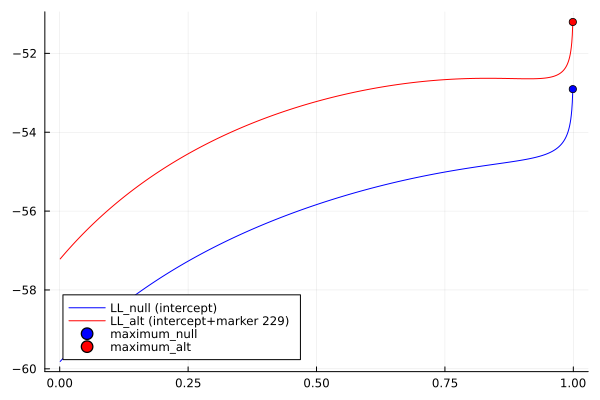

In [214]:
plot(hsqs, full_results[1], color = "blue", label = "LL_null (intercept)", legend =:bottomleft)
plot!(hsqs, full_results[2], color = "red", label = "LL_alt (intercept+marker 229)")
scatter!([hsqs[max_noBayes_null[2]]], [max_noBayes_null[1]], color = "blue", label = "maximum_null")
scatter!([hsqs[max_noBayes_alt[2]]], [max_noBayes_alt[1]], color = "red", label = "maximum_alt")

In [215]:
hsqs_from_alt_b[229]

0.7196223579166907

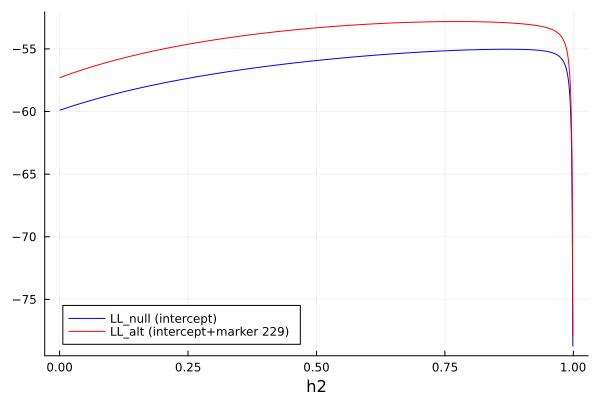

In [239]:
plot(hsqs, full_results[3], color = "blue", label = "LL_null (intercept)", xlabel = "h2", legend =:bottomleft)
plot!(hsqs, full_results[4], color = "red", label = "LL_alt (intercept+marker 229)")
# scatter!([hsqs[max_noBayes_null[2]]], [max_noBayes_null[1]], color = "blue", label = "maximum_null")
# scatter!([hsqs_from_alt_b[229]], [], color = "red", label = "maximum_alt")

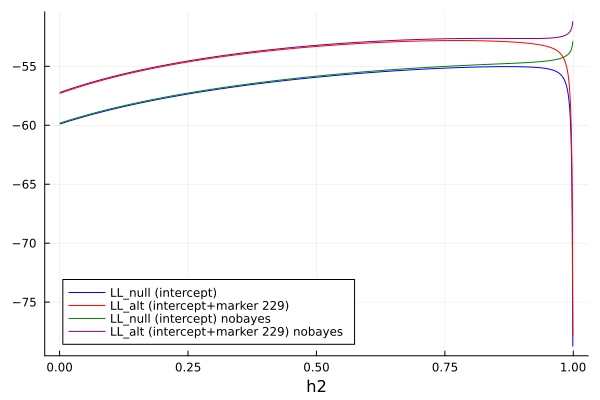

In [216]:
plot(hsqs, full_results[3], color = "blue", label = "LL_null (intercept)", xlabel = "h2", legend =:bottomleft)
plot!(hsqs, full_results[4], color = "red", label = "LL_alt (intercept+marker 229)")
plot!(hsqs, full_results[1], color = "green", label = "LL_null (intercept) nobayes")
plot!(hsqs, full_results[2], color = "purple", label = "LL_alt (intercept+marker 229) nobayes")
# scatter!([hsq_from_null_b], [full_results[3][Int(floor(hsq_from_null_b*100))]], color = "blue", label = "maximum_null")
# scatter!([hsqs_from_alt_b[229]], [full_results[4][Int(floor(hsqs_from_alt_b[229]*100))]], color = "red", label = "maximum_alt")

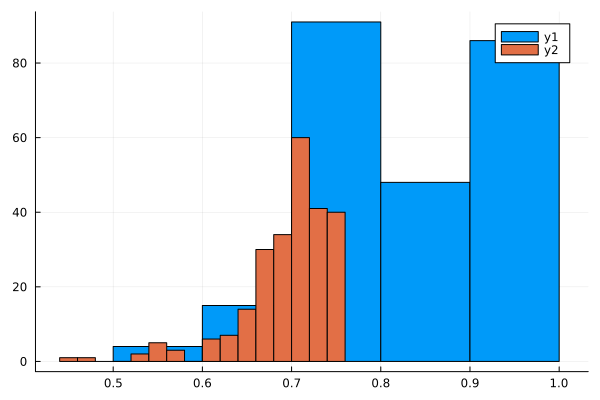

In [217]:
hsqs_assoc_neg = hsqs_from_alt[findall(lods_from_alt .< 0)];
hsqs_assoc_neg_b = hsqs_from_alt_b[findall(lods_from_alt .< 0)];
histogram(hsqs_assoc_neg)
histogram!(hsqs_assoc_neg_b)

## Assuming what we do is correct...

In [218]:
?fitlmm

search: fitlmm FisherNoncentralHypergeometric



fitlmm: fit linear mixed model using grid of values

y: 2-d array of (rotated) phenotypes X: 2-d array of (rotated) covariates lambda: 1-d array of eigenvalues ngrid: number of grid values to consider

---

fitlmm: fit linear mixed model

y: 2-d array of (rotated) phenotypes X: 2-d array of (rotated) covariates lambda: 1-d array of eigenvalues reml: boolean indicating ML or REML estimation


In [219]:
function scan_alt_corrected(y::Array{Float64, 2}, g::Array{Float64, 2}, K::Array{Float64, 2}; 
                  prior::Array{Float64, 1} = [0.0, 0.0],
                  reml::Bool = false, method::String = "qr")

    # number of markers
    (n, p) = size(g);
    
    # rotate data
    (y0, X0, lambda0) = transform_rotation(y, g, K);

    pve_list = Array{Float64, 1}(undef, p);

    X00 = reshape(X0[:, 1], :, 1);
    # fit null lmm
    # out00 = fitlmm(y0, X00, lambda0; reml = reml, method = method);
    # out00 = fitlmm(y0, X00, lambda0; reml = reml);

    lod = zeros(p);
    X = zeros(n, 2);
    X[:, 1] = X0[:, 1];
    
    out00_bayes = fitlmm(y0, X00, lambda0, prior; reml = reml, method = method);
    
    for i = 1:p
        X[:, 2] = X0[:, i+1];
        
        # out11 = fitlmm(y0, X, lambda0; reml = reml, method = method);
        # out11 = fitlmm(y0, X, lambda0; reml = reml);
        
        # curr_lod = (out11.ell - out00.ell)/log(10);
        # curr_h2 = out11.h2;
        
        # Check results validity
        if true
            # out00_bayes = fitlmm(y0, X00, lambda0, prior; reml = reml, method = method);
            out11_bayes = fitlmm(y0, X, lambda0, prior; reml = reml, method = method);
            
            curr_lod = (out11_bayes.ell - out00_bayes.ell)/log(10);
            curr_h2 = out11_bayes.h2;
        end
        
        
        pve_list[i] = curr_h2;
        lod[i] = curr_lod;
        
    end

    return (out00_bayes.sigma2, out00_bayes.h2, pve_list, lod)

end

scan_alt_corrected (generic function with 1 method)

In [220]:
prior

2-element Vector{Float64}:
 1.6944289276209026
 0.1

In [221]:
prior = [var(pheno[:, 108]), 0.1];

In [222]:
var(pheno[:, 108])

1.6944289276209026

In [223]:
results_corrected = scan_alt_corrected(pheno_108, geno, kinship_Gc; prior = prior, reml = false, method = "qr");

In [224]:
hcat(results_scan_alt[4], results_corrected[4], lods_from_gemma[:, 108])

7321×3 Matrix{Float64}:
 0.0219153  0.0199953  0.0219155
 0.0219153  0.0199953  0.0219155
 0.0219153  0.0199953  0.0219155
 0.0219153  0.0199953  0.0219155
 0.0219153  0.0199953  0.0219155
 0.0219153  0.0199953  0.0219155
 0.0219153  0.0199953  0.0219155
 0.0219153  0.0199953  0.0219155
 0.0219153  0.0199953  0.0219155
 0.0219153  0.0199953  0.0219155
 0.0219153  0.0199953  0.0219155
 0.021912   0.0199922  0.0219122
 0.0567256  0.0417663  0.0567251
 ⋮                     
 0.248678   0.263758   0.248678
 0.248678   0.263758   0.248678
 0.248678   0.263758   0.248678
 0.0686881  0.122407   0.0686887
 0.124881   0.136544   0.124882
 0.124881   0.136544   0.124882
 0.249213   0.255818   0.249213
 0.273645   0.288192   0.273645
 0.271594   0.285219   0.271594
 0.285893   0.309153   0.285893
 0.229505   0.219606   0.229504
 0.229505   0.219606   0.229504

In [225]:
isNegative = findall(results_scan_alt[4] .< 0)

244-element Vector{Int64}:
  229
  230
  231
  232
  233
  234
  235
  236
  237
  238
  239
  240
  241
    ⋮
 6112
 6113
 6114
 6115
 6116
 6117
 6118
 6119
 6123
 6124
 7227
 7228

In [226]:
findall(results_corrected[4] .< 0)

Int64[]

In [227]:
summary_corrected = hcat(results_scan_alt[4][isNegative], results_corrected[4][isNegative], lods_from_gemma[:, 108][isNegative]);
summary_corrected = vcat(["before" "corrected_by_bayes" "gemma"], summary_corrected)

245×3 Matrix{Any}:
   "before"   "corrected_by_bayes"   "gemma"
 -2.2873     0.960429               0.736546
 -2.2873     0.960429               0.736546
 -2.2873     0.960429               0.736546
 -2.36798    0.896445               0.582913
 -1.41325    1.8579                 1.3266
 -1.50067    1.76317                1.30913
 -1.67281    1.59201                1.16035
 -1.67281    1.59201                1.16035
 -1.90021    1.36665                0.930859
 -1.90021    1.36665                0.930859
 -1.90013    1.36673                0.930918
 -1.55903    1.70945                1.16779
  ⋮                                 
 -2.9462     0.334003               0.0473551
 -2.94618    0.334022               0.0473611
 -2.94618    0.334022               0.0473611
 -2.16293    1.10493                0.77996
 -2.51206    0.748722               0.525381
 -2.57682    0.675707               0.475996
 -2.57682    0.675707               0.475996
 -2.46246    0.800337               0.582341
 -2

In [228]:
maximum(abs.(results_corrected[4][isNegative] .- lods_from_gemma[:, 108][isNegative]))

0.5689574348320452

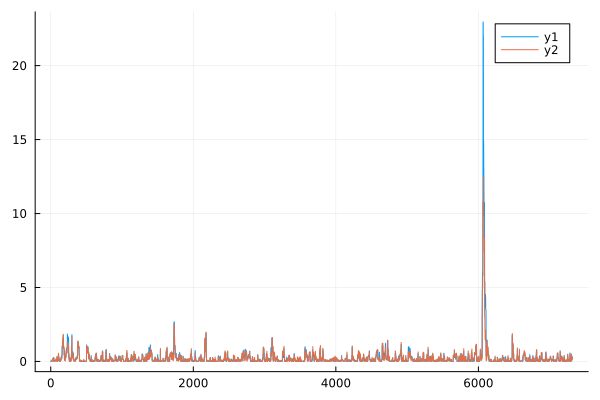

In [242]:
plot(results_corrected[4])
plot!(lods_from_gemma[:, 108])

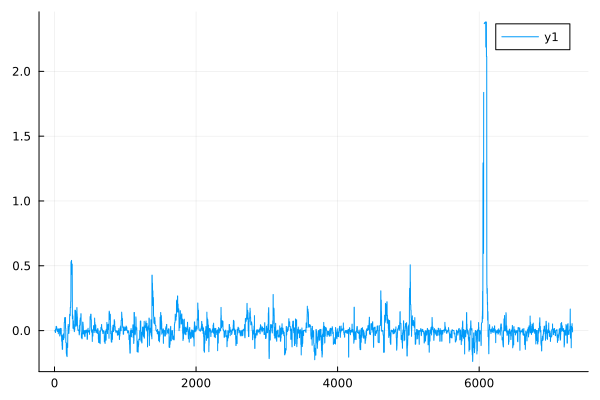

In [244]:
plot(results_corrected[4] .- lods_from_gemma[:, 108])

In [245]:
pheno_19 = reshape(pheno[:, 19], :, 1);

In [246]:
@time test19_perms = scan_perms(pheno_19, geno, kinship_Gc; prior_a = 1.0, prior_b = 0.1, nperms = 1000, original = true);

  6.706466 seconds (103.87 k allocations: 17.629 GiB, 4.69% gc time)


In [254]:
vec(maximum(test19_perms; dims = 2))

1001-element Vector{Float64}:
 2.9300091589620254
 2.56143981965196
 1.9160676261812617
 2.076514983115319
 2.0948530010863267
 2.3389169845043556
 2.4127272413227567
 3.0578852420095397
 2.383781942481602
 2.7469149969858604
 2.219515879059508
 2.5098684168380014
 4.12296156262523
 ⋮
 2.191607518169967
 2.4967360282982134
 2.266047863469006
 2.706340075950865
 1.8912506959325832
 3.406082779921701
 2.778746177646514
 2.2181469525486435
 2.3188610916479284
 2.2293271497998375
 2.204037432599552
 2.0997323448398273

In [256]:
quantile(vec(maximum(test19_perms; dims = 2)), 0.95)

3.8059944534366568

In [257]:
@time test19_perms_nc = scan_perms(pheno_19, geno, kinship_Gc; prior_a = 0.0, prior_b = 0.0, nperms = 1000, original = true);

  6.342335 seconds (103.89 k allocations: 17.629 GiB, 3.41% gc time)


In [258]:
vec(maximum(test19_perms_nc; dims = 2))

1001-element Vector{Float64}:
 2.9285601677812743
 2.5622831160261024
 1.9165318033820595
 2.0770730631941605
 2.0962923614298705
 2.3399265262757236
 2.4130901247579573
 3.0592809086337844
 2.3859789054066165
 2.748545786655191
 2.2189915539803
 2.510207649489784
 4.124379652987201
 ⋮
 2.1931064226899246
 2.496873334868151
 2.2670793201587855
 2.7071205204216433
 1.8930539065036933
 3.404812819310837
 2.779333912811678
 2.216748097558599
 2.320204289589407
 2.2310111997171154
 2.203517699413064
 2.100859545403448

In [259]:
quantile(vec(maximum(test19_perms_nc; dims = 2)), 0.95)

3.806599912713779

In [229]:
pheno_y = reshape(pheno[:, 109], :, 1);

In [230]:
prior = [var(pheno[:, 109]), 1/10];

In [231]:
@btime scan_alt_corrected(pheno_y, geno, kinship_Gc; prior = prior, reml = false, method = "qr");

  1.742 s (2631704 allocations: 1.18 GiB)


In [240]:
@btime scan_alt(pheno_y, geno, kinship_Gc; reml = false);

LoadError: MethodError: no method matching scan_alt(::Matrix{Float64}, ::Matrix{Float64}, ::Matrix{Float64}; reml=false)
[0mClosest candidates are:
[0m  scan_alt(::Matrix{Float64}, ::Matrix{Float64}, ::Matrix{Float64}, [91m::Vector{Float64}[39m; reml) at In[163]:1
[0m  scan_alt(::Matrix{Float64}, ::Matrix{Float64}, ::Matrix{Float64}, [91m::Vector{Float64}[39m, [91m::Bool[39m; reml, method) at ~/git/BulkLMM.jl/src/scan.jl:151

In [233]:
@btime scan_alt_corrected(pheno_y, geno, kinship_Gc; prior = prior, reml = false, method = "cholesky");

  1.177 s (2270915 allocations: 941.10 MiB)
